In [4]:
import ee
import numpy as np
import pandas as pd

from earthshot import mon_stats
from earthshot import water_viz as vis
from earthshot import normalize as norm
from earthshot import water_common as common
from statistics import mean

import geemap.eefolium as geemap
import folium
from folium import plugins

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
ee.Initialize()

In [28]:
#Join beaver dam tables

def set_present(feature):
    return feature.set('Beaver Dam', 1)

def set_absent(feature):
    return feature.set('Beaver Dam', 0)

CA_Dam_Data_Present = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/06_CaliforniaDams_Boxes_yes_BeaverDam')
CA_Dam_Data_Absent = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/06_CaliforniaDams_Boxes_no_BeaverDam')
CO_Dam_Data_Present = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_yes_BeaverDam').merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_allIntersect'))
CO_Dam_Data_Absent = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_no_BeaverDam')
ID_Dam_Data_Present = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_yes_BeaverDam').merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_allIntersect'))
ID_Dam_Data_Absent = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_no_BeaverDam')
WY_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_yes_BeaverDam')
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_allIntersect'))
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_yes_BeaverDam'))
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_allIntersect')))
WY_Dam_Data_Absent = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_no_BeaverDam')
                      .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_yes_BeaverDam')))
OR_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_yes_BeaverDam')
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_allIntersect')))
OR_Dam_Data_Absent = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_no_BeaverDam')

dam_data_present = (CA_Dam_Data_Present.merge(CO_Dam_Data_Present).merge(ID_Dam_Data_Present).merge(WY_Dam_Data_Present).merge(OR_Dam_Data_Present)).map(set_present)

dam_data_absent_pre = CA_Dam_Data_Absent.merge(CO_Dam_Data_Absent).merge(ID_Dam_Data_Absent).merge(WY_Dam_Data_Absent).merge(OR_Dam_Data_Absent).map(set_absent)

split = 0.75
random = dam_data_absent_pre.randomColumn()
dam_data_absent = random.filter(ee.Filter.gte('random', split))

dam_data = dam_data_present.merge(dam_data_absent)

In [7]:
eco_regions = ee.FeatureCollection('users/amgadellaboudy/Eco_Regions')

innerJoin = ee.Join.inner()
def cleanJoin(feature):
    new_feature = ee.Feature(feature.get('primary')).copyProperties(feature.get('secondary'))
    return new_feature

spatialFilter = ee.Filter.intersects(leftField = '.geo', rightField = '.geo', maxError = 10)
eco_dam_data = innerJoin.apply(dam_data, eco_regions, spatialFilter)
eco_dam_data_clean = eco_dam_data.map(cleanJoin)
dam_feat = eco_dam_data_clean.remap(lookupIn = ['16', '21', '5'], lookupOut = [0, 1, 2], columnName = 'US_L3CODE')


In [8]:
bbox_conus = ee.Geometry.BBox(-125, 30, -103, 49)
bbox_global = ee.Geometry.BBox(-180, -90, 180, 90)

#Import variables in (Slope, Porosity, Runoff, Soil Types, Annual Precipitation, water accumulation)
slope_img = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope')
#slope_global = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope')
#Scale = 90 m

temp_img = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2020-01-01', '2020-12-31').select('temperature_2m').mean().clip(bbox_conus)
#temp_global = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2020-01-01', '2020-12-31').select('temperature_2m').mean()

runoff_img = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2020-01-01', '2020-12-31').select('surface_runoff').mean().clip(bbox_conus)
#runoff_clim_m = mon_stats.bands_avgs(['surface_runoff'], runoff_clim)
#runoff_img = ee.ImageCollection(runoff_clim_m['avgs'].get('surface_runoff')).sum().multiply(720)
#runoff_max = runoff_clim.max().multiply(720)

precip_img = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2020-01-01', '2020-12-31').select('total_precipitation').mean().clip(bbox_conus)

#precip_clim = ee.Image("OpenLandMap/CLM/CLM_PRECIPITATION_SM2RAIN_M/v01")
#precip_img = precip_clim.reduce('sum')
#https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_CLM_CLM_PRECIPITATION_SM2RAIN_M_v01#bands
#Scale = 1 km

soil_types = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")

top_soils = soil_types.expression('soil_0 + soil_10 + soil_30',
                             {'soil_0': soil_types.select('b0'),
                             'soil_10': soil_types.select('b10'),
                             'soil_30': soil_types.select('b30')}).clip(bbox_conus)

water_img = ee.Image("MERIT/Hydro/v1_0_1").select('viswth').clip(bbox_conus)
#print(norm.img_range(water_img))
#https://developers.google.com/earth-engine/datasets/catalog/MERIT_Hydro_v1_0_1#bands
#Scale = 90 m



In [9]:
#function to calculate NDVI

def addNDVI(image):
    ndvi = image.normalizedDifference(['N', 'R']).rename('NDVI')
    return image.addBands(ndvi)

In [10]:
NDVI_pre = (ee.ImageCollection('USDA/NAIP/DOQQ')
        .filterDate('2016-01-01', '2018-12-31')
        .map(addNDVI)
        .select('NDVI')
        .mean()
        .clip(bbox_conus))

mask = NDVI_pre.gte(-0.25)
NDVI = NDVI_pre.updateMask(mask)

In [11]:
training_img = slope_img.addBands(runoff_img).addBands(precip_img).addBands(top_soils).addBands(NDVI).addBands(temp_img)
print(training_img.bandNames().getInfo())

['slope', 'surface_runoff', 'total_precipitation', 'b0', 'NDVI', 'temperature_2m']


In [29]:
target = 'NDVI'
bands = ['slope', 'surface_runoff', 'total_precipitation', 'b0', 'temperature_2m', 'Beaver Dam']
not_null = ['NDVI', 'slope', 'surface_runoff', 'total_precipitation', 'b0','temperature_2m', 'Beaver Dam']



training = (training_img.reduceRegions(collection = dam_data, reducer = ee.Reducer.mean(), scale = 2, tileScale = 16)).filter(ee.Filter.notNull(not_null))

In [217]:
selectors = ee.List(['Beaver Dam', 'NDVI', 'slope', 'surface_runoff', 'temperature_2m', 'total_precipitation','b0'])

training_df = pd.DataFrame(training.reduceColumns(reducer = ee.Reducer.toList().repeat(selectors.size()), selectors = selectors).get('list').getInfo()).transpose()

training_df = training_df.rename(columns = {0: 'Beaver Dam', 1: 'NDVI', 2: 'slope', 3: 'surface_runoff', 4: 'temperature_2m', 5: 'total_precipitation', 6: 'Soil Type'})

training_df.head()

,Beaver Dam,NDVI,slope,surface_runoff,temperature_2m,total_precipitation,Soil Type
0,1.0,0.253768,2.918741,0.000040,281.962162,0.000697,27.000000
1,1.0,0.288047,2.667730,0.000043,283.601159,0.000683,27.000000
2,1.0,0.177025,2.726323,0.000040,281.962162,0.000697,21.354575
3,1.0,0.211482,3.148325,0.000040,281.962162,0.000697,21.753414
4,1.0,0.234640,3.701855,0.000040,281.962162,0.000697,26.541020


In [218]:
X = training_df.drop('NDVI', axis =1).values
y = training_df['NDVI'].values

In [219]:
from sklearn.model_selection import train_test_split

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [221]:
from sklearn.preprocessing import MinMaxScaler

In [222]:
scaler= MinMaxScaler()

In [223]:
X_train = scaler.fit_transform(X_train)
len(X_train)

4445

In [224]:
X_test = scaler.transform(X_test)

In [225]:
import tensorflow.keras as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [236]:
model = Sequential()

model.add(Dense(6, activation='relu'))
model.add(Dense(635, activation='relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer='adam', loss = 'mse')

In [237]:
callback = tf.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=25, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.fit(x = X_train, y = y_train, callbacks = callback,
          validation_data = (X_test,y_test),
         batch_size = 16, epochs = 1000)

Epoch 1/1000
278/278 [==============================] - 1s 3ms/step - loss: 0.0125 - val_loss: 0.0090
Epoch 2/1000
278/278 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0103
Epoch 3/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 4/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 5/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 6/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 7/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 8/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 9/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 10/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.008

278/278 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 81/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 82/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0081
Epoch 83/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 84/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 85/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 86/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 87/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 88/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 89/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0076 - v

In [238]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

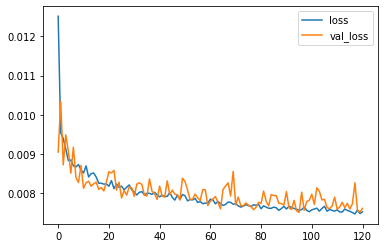

In [239]:
losses.plot()

In [240]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [241]:
predictions = model.predict(X_test)

In [242]:
np.sqrt(mean_squared_error(y_test,predictions))

0.08725806923707731

In [243]:
explained_variance_score(y_test, predictions)

0.5856784873589109

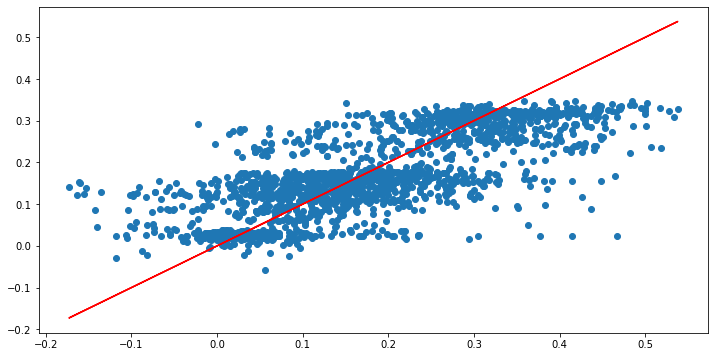

In [244]:
plt.figure(figsize = (12,6))
plt.scatter(y_test,predictions)
plt.plot(y_test, y_test, 'r')